# Final Project Stock Suggestion Expert system
## Dheeraj Reddy: 100811270
## Purnima: Yadav 100800499
## Pooja: 100799175
## Vasundhara: 100800734

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
base = 'https://www.prnewswire.com'
from IPython.display import clear_output

In [2]:
def no_of_news(number):
    url='https://www.prnewswire.com/news-releases/news-releases-list/'
    #url_new = '?page=1&pagesize=' + str(number)
    url_new = '?month=02&day=26&year=2021&hour=09&page=1&pagesize=' + str(number)
    response=requests.get(url+url_new)
    return response
def get_ticker(results_page):
  all_a_tags = results_page.find_all('a',class_='newsreleaseconsolidatelink display-outline')
  for tag in all_a_tags:
    all_news.append(tag.text)
    new_url = tag.get('href')
    new_response = requests.get(base+new_url)
    new_page = BeautifulSoup(new_response.content,'lxml')
    tkr = new_page.find_all('a',class_='ticket-symbol')
    for tk in tkr:
      if tk is not None:
        if len(tk.get_text()) > 0:
          ref_links.append(base+new_url)
          #print(tk.get_text())
          ticker.append(tk.get_text())
          ticker_news[tk.get_text()] = tag.text

def share_data(share,delta):
    end=datetime.datetime.today()
    start=end-datetime.timedelta(days=delta)
    df = pdr.get_data_yahoo(share,start,end)
    return df

def get_signal_df(share_tick):
  try:
    trial_df = share_data(share_tick,365)
  except:
    return None
  trial_df['MA_26'] = trial_df['Close'].ewm(span=26,adjust=False).mean()
  trial_df['MA_12'] = trial_df['Close'].ewm(span=12,adjust=False).mean()
  trial_df['MACD'] = trial_df['MA_12'] - trial_df['MA_26']
  trial_df['Signal_line'] = trial_df['MACD'].ewm(span=9,adjust=False).mean()
  trial_df['Signal'] = trial_df['MACD'] - trial_df['Signal_line']
  trial_df['Signal_color'] = np.where(trial_df['Signal']>0,'g','r')

  trial_df['L14'] = trial_df['Low'].rolling(window=14).min()

  #Create the "H14" column in the DataFrame
  trial_df['H14'] = trial_df['High'].rolling(window=14).max()

  #Create the "%K" column in the DataFrame
  trial_df['K_line'] = 100*((trial_df['Close'] - trial_df['L14']) / (trial_df['H14'] - trial_df['L14']))
  trial_df['D_line'] = trial_df['K_line'].rolling(window=3).mean()
  trial_df['Sto_sig'] = trial_df['K_line'] - trial_df['D_line']
  trial_df['Sto_color'] = np.where(trial_df['Sto_sig']>0,'g','r')
  trial_df['Sell_line'] = 80
  trial_df['Buy_line'] = 20

  return trial_df

def plot_signals(trial_df):
  fig, ax = plt.subplots(3, 1,figsize=(20,20))
  ax[0].set_title("Share Price pattern over last year")
  ax[0].plot(trial_df.index,trial_df['Close'], label = 'Close Price')
  ax[0].plot(trial_df.index,trial_df['MA_26'], label = 'Moving Average 26 days')
  ax[0].plot(trial_df.index,trial_df['MA_12'], label = 'Moving Average 12 days')
  ax[0].legend(loc="upper left")
  ax[1].set_title("MACD Plot")
  ax[1].plot(trial_df.index,trial_df['MACD'], label = 'MACD Line')
  ax[1].plot(trial_df.index,trial_df['Signal_line'], label = 'Signal line')
  ax[1].bar(trial_df.index,trial_df['Signal'],color = trial_df['Signal_color'] )
  ax[1].legend(loc="upper left")
  ax[2].set_title("Stochastic indicator plot")
  ax[2].plot(trial_df.index,trial_df['K_line'], color = 'c', label = 'K-line')
  ax[2].plot(trial_df.index,trial_df['D_line'],color = 'm', label = 'D-line')
  ax[2].plot(trial_df.index,trial_df['Buy_line'],color = 'g', label = 'oversold-line')
  ax[2].plot(trial_df.index,trial_df['Sell_line'],color = 'r', label = 'overbought-line')
  ax[2].bar(trial_df.index,trial_df['Sto_sig'],color = trial_df['Sto_color'] )
  ax[2].legend(loc="upper left")


def MACD_expert(ticker):
  trial_df = get_signal_df(ticker)
  if trial_df is None:
    return None
  if trial_df['Signal'].iloc[-1] > 0:
    return 'Buy'
  else:
    return 'Sell'

def Stochastic_expert(ticker):
  trial_df = get_signal_df(ticker)
  if trial_df is None:
    return None
  if trial_df['K_line'].iloc[-1] < 20:
    insight = 'This Stock is oversold recently'
    if trial_df['Sto_sig'].iloc[-1] > 0 and trial_df['Sto_sig'].iloc[-2] < 0:
      decision = 'Strong-Buy'
    elif trial_df['Sto_sig'].iloc[-1] > 0 and trial_df['Sto_sig'].iloc[-2] > 0:
      decision = 'Buy'
    elif trial_df['Sto_sig'].iloc[-1] < 0 and trial_df['Sto_sig'].iloc[-2] > 0:
      decision = 'Short-term-Sell'
    else:
      decision = 'Hold'
  elif trial_df['K_line'].iloc[-1] > 80:
    insight = 'This Stock is overbought recently'
    if trial_df['Sto_sig'].iloc[-1] < 0 and trial_df['Sto_sig'].iloc[-2] > 0:
      decision = 'Strong-Sell'
    elif trial_df['Sto_sig'].iloc[-1] < 0 and trial_df['Sto_sig'].iloc[-2] < 0:
      decision = 'Sell'
    elif trial_df['Sto_sig'].iloc[-1] > 0 and trial_df['Sto_sig'].iloc[-2] < 0:
      decision = 'Short-term-Buy'
    else:
      decision = 'Hold'
  else:
    insight = 'This stock has a steady trend'
    if trial_df['Sto_sig'].iloc[-1] > 0 and trial_df['Sto_sig'].iloc[-2] < 0:
      decision = 'Buy'
    if trial_df['Sto_sig'].iloc[-1] < 0 and trial_df['Sto_sig'].iloc[-2] > 0:
      decision = 'Sell'
    else :
      decision = 'Hold'
  return [insight,'It is recommended to '+ decision]


## Stock suggestions from User Portfolio

In [11]:
ticker = []
print(f'Enter the tickers in your portfolio one by one')
print(f'Once done press "e" key on your keyboard')
k = 0
while True:
  k += 1
  ticker.append(input(f'Share No.{k}: '))
  if ticker[-1] == 'e':
    break
ticker.pop(-1)
ticker_decision = dict()
for tick in ticker:
  data = Stochastic_expert(tick)
  macd = MACD_expert(tick)
  if data is not None:
    [insight,decision] = data
    share_price = share_data(tick,5)['Close'].iloc[-1]
    ticker_decision[tick] = [np.round(share_price,2), macd, insight, decision]
  else:
    print(f'Unable to retrive data for {tick}')
decision_df = pd.DataFrame.from_dict(ticker_decision, orient='index',columns = ['Current Share Price','MACD_indicator','Stochastic indicator insights',
                                                                                'Stochastic indicator Recommendation' ])
print(f'Here are our insights on your portfolio')
decision_df

Enter the tickers in your portfolio one by one
Once done press "e" key on your keyboard
Share No.1: aapl
Share No.2: msft
Share No.3: amzn
Share No.4: abc
Share No.5: abcd
Share No.6: e
Unable to retrive data for abcd
Here are our insights on your portfolio


,Current Share Price,MACD_indicator,Stochastic indicator insights,Stochastic indicator Recommendation
aapl,127.57,Buy,This Stock is overbought recently,It is recommended to Hold
msft,250.49,Buy,This Stock is overbought recently,It is recommended to Short-term-Buy
amzn,3296.87,Buy,This Stock is overbought recently,It is recommended to Short-term-Buy
abc,116.08,Sell,This stock has a steady trend,It is recommended to Hold


## Insights on Trending tickers

In [4]:
all_news = []
ticker = []
ref_links = []
ticker_news = dict()
ticker_decision = dict()
response = no_of_news(50)
results_page = BeautifulSoup(response.content,'lxml')
get_ticker(results_page)
ticker = list(set(ticker))
for tick in ticker:
  data = Stochastic_expert(tick)
  macd = MACD_expert(tick)
  if data is not None:
    [insight,decision] = data
    share_price = share_data(tick,5)['Close'].iloc[-1]
    ticker_decision[tick] = [np.round(share_price,2), macd, insight, decision]
decision_df = pd.DataFrame.from_dict(ticker_decision, orient='index',columns = ['Current Share Price in $','MACD_indicator','Stochastic indicator insights',
                                                                                'Stochastic indicator Recommendation' ])
print(f'Here are our insights on the trending tickers')
decision_df

Here are our insights on the trending tickers


,Current Share Price in $,MACD_indicator,Stochastic indicator insights,Stochastic indicator Recommendation
ACRDF,2.97,Sell,This stock has a steady trend,It is recommended to Hold
SNDL,1.01,Sell,This Stock is oversold recently,It is recommended to Strong-Buy
CLVT,26.22,Buy,This stock has a steady trend,It is recommended to Hold
MLCO,20.68,Sell,This stock has a steady trend,It is recommended to Sell
SPNT,10.38,Sell,This stock has a steady trend,It is recommended to Sell
STLA,18.21,Buy,This Stock is overbought recently,It is recommended to Strong-Sell
D,76.02,Buy,This stock has a steady trend,It is recommended to Sell
ACRHF,5.83,Buy,This stock has a steady trend,It is recommended to Hold
CGC,29.99,Sell,This Stock is oversold recently,It is recommended to Hold
MDC,60.41,Buy,This Stock is overbought recently,It is recommended to Strong-Sell


## Vizualizing a Ticker

Enter the ticker code you want to vizualize: msft


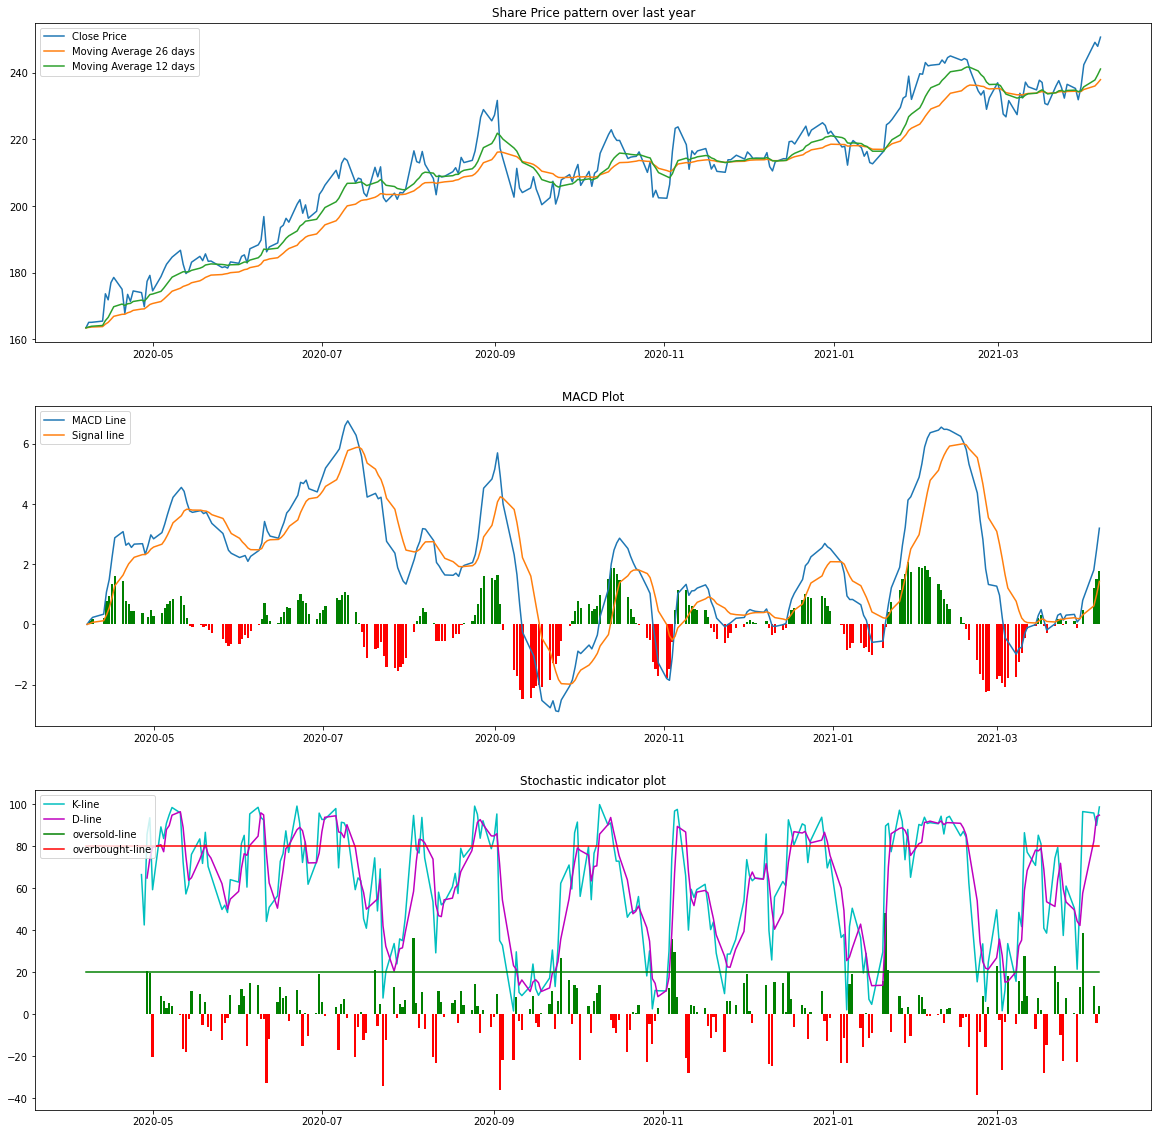

In [10]:
share_tick = input(f'Enter the ticker code you want to vizualize: ')
try:
  trial_df = get_signal_df(share_tick)
except:
  print('Unable to retrieve data for the ticker entered')
  trial_df = None
if trial_df is not None:
  plot_signals(trial_df)
